# BUSN 20800 Big Data Final project

## Due date: March 8th, 2024, 11:59 a.m. (not p.m.!)

# Problem 1: Text Analysis of Presidents' Addresses (50 points)

The State of the Union is an annual address by the President of the United States before a joint session of congress. In it, the President reviews the previous year and lays out his legislative agenda for the coming year. This dataset contains the full text of the State of the Union address from 1790 (Washington) to 2021 (Biden). http://stateoftheunion.onetwothree.net/texts/index.html

In this project, you are requested to analyze the addresses delivered by presidents. All functions are provided as given and you don't need to modify any of them.

Run the following codes to load the data, you don't need to modify any codes here.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pylab as py
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from tqdm import tqdm
import pickle

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier


In [2]:
#Step 1: Load Data
open_file = open('speech', "rb")
speeches = pickle.load(open_file)
open_file.close()

df_speech = pd.DataFrame(speeches)
df_speech.head()

,president,text,year
0,James Monroe,Fellow-Citizens of the Senate and House of Re...,1821
1,William McKinley,To the Senate and House of Representatives:\r...,1897
2,Dwight D. Eisenhower,[Delivered in person before a joint session] \...,1960
3,Calvin Coolidge,Since the close of the last Congress the Natio...,1923
4,James Madison,Fellow-Citizens of the Senate and House of Re...,1816


#  Part I. LDA model (10 points)

### What is LDA?

latent Dirichlet allocation (LDA) is a generative probabilistic model for collections ofdiscrete data such as text corpora. LDA is a three-level hierarchical Bayesian model, in which each item of a collection is modeled as a finite mixture over an underlying set of topics. The "latent" part of LDA refers to the fact that the topic structure—the topics themselves, the distribution of topics in each document, and the distribution of words in each topic—are hidden structures that the model aims to learn from the observed documents.

Here are some key concepts:

- Document: In LDA, a document is a sequence of words. A document can be as long or as short as desired, but LDA typically works best with documents that are not too short, as longer documents provide more context for learning relationships between words.

- Corpus: A collection of documents. The corpus is the entire dataset that you wish to analyze using LDA.

- Topic: An abstract theme or subject area that is prevalent across a collection of documents. In LDA, a topic is represented as a distribution over words, meaning that each topic is characterized by certain words that are more likely to appear in that topic.

- Word: The basic unit of text analysis in LDA. Words are considered tokens and are the elements that are distributed across topics.

Link of the original paper: https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

Run the following codes to preprocess the data, you don't need to modify any codes here.

In [3]:
#!pip install pyLDAvis # run this code if you don't have this package

In [4]:
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/shivanipuli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shivanipuli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shivanipuli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/shivanipuli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shivanipuli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def get_wordnet_pos(treebank_tag):
    """
    Convert treebank tag to wordnet tag.
    
    Parameters:
    - treebank_tag (str): The part-of-speech tag in Penn Treebank notation.
    """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ  # Adjective
    elif treebank_tag.startswith('V'):
        return wordnet.VERB  # Verb
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN  # Noun
    elif treebank_tag.startswith('R'):
        return wordnet.ADV   # Adverb
    else:
        return wordnet.VERB  # Default to verb

In [6]:
def normalizeText(input):
    """
    Cleans and normalizes the input text by removing various types of characters and patterns.

    Parameters:
    - input (str): The text to be normalized.
    """
    text = re.sub(r'\n+', " ", input)  # change \n to " "
    text = re.sub(r'\[[0-9]*\]', "", text)  # Delete [1]
    text = re.sub(r' +', " ", text)  # Change several " " to one " "
    text = re.sub(r'\(end\)', "", text)  # Delete (end)

    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#([^\s]+)', '', text)
    text = re.sub(r'[:;>?<=*+()&,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]', ' ', text)  # Special char
    text = re.sub(r'[\d]', '', text)  # decimal digit
    text = text.replace(".", '')  # Delete .
    text = text.replace("`", '')  # Delete `
    text = text.replace("'s", '')  # Delete 's
    text = text.replace("'", '')  # Delete '
    text = text.replace("/", ' ')
    text = text.replace("\"", ' ')
    text = text.replace("\\", '')
    text = re.sub(r"\b[a-z]\b", "", text)
    text = re.sub(r'\s+', ' ', text)  # Delete \s

    text = text.strip()  # delete spaces at beginning and ending

    return text

In [7]:
def clean_word(text):
    """
    The function leverages NLTK for tokenization, stopword removal, 
    part-of-speech tagging, and lemmatization.
    
    Parameters:
    - text (str): The text to be cleaned and processed.
    """

    text = text.lower()
    text = normalizeText(text)
    tokenized_text = nltk.word_tokenize(text)
    word = [w for w in tokenized_text if w.isalpha()]
    
    # delete stop words
    stop_words = set(stopwords.words('english'))  # Stopwords_set
    stop_words.add('could')
    stop_words.add('would')
    stop_words.add('shall')
    tokens = [w for w in word if not w in stop_words]
        
    # lemmatize
    res    = []
    for w, pos in nltk.tag.pos_tag(tokens):
        wordnet_pos = get_wordnet_pos(pos)
        res.append(WordNetLemmatizer().lemmatize(w, pos=wordnet_pos))
    return res

In [8]:
df_speeches = pd.DataFrame(speeches)
df_speeches.head()

,president,text,year
0,James Monroe,Fellow-Citizens of the Senate and House of Re...,1821
1,William McKinley,To the Senate and House of Representatives:\r...,1897
2,Dwight D. Eisenhower,[Delivered in person before a joint session] \...,1960
3,Calvin Coolidge,Since the close of the last Congress the Natio...,1923
4,James Madison,Fellow-Citizens of the Senate and House of Re...,1816


In [9]:
%%time
cleaned_word = df_speeches['text'].map(clean_word)
df_speeches['word'] = cleaned_word

df_speeches.head()

CPU times: user 46 s, sys: 172 ms, total: 46.2 s
Wall time: 46.5 s


,president,text,year,word
0,James Monroe,Fellow-Citizens of the Senate and House of Re...,1821,"[fellow, citizen, senate, house, representativ..."
1,William McKinley,To the Senate and House of Representatives:\r...,1897,"[senate, house, representative, give, pleasure..."
2,Dwight D. Eisenhower,[Delivered in person before a joint session] \...,1960,"[deliver, person, joint, session, mr, presiden..."
3,Calvin Coolidge,Since the close of the last Congress the Natio...,1923,"[since, close, last, congress, nation, lose, p..."
4,James Madison,Fellow-Citizens of the Senate and House of Re...,1816,"[fellow, citizen, senate, house, representativ..."


**Exercise 1:** Perform LDA on these speeches and visualize the topic models. What's your conclusion?

(You can try different parameters to see the difference.)

**Your Answer here:**



In [10]:
# To avoid warnings during visualization, you need to run the below codes.
#!pip install --upgrade bottleneck
#!pip install pyLDAvis.sklearn

In [11]:
dictionary = gensim.corpora.Dictionary(df_speeches['word'])
dictionary.filter_extremes(no_above=0.6,no_below=60)
corpus = [dictionary.doc2bow(doc) for doc in df_speeches['word']]

lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=4, passes=20,random_state = 1)

vis_data1 = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data1)

### Analysis:
When I first ran the model with no filtering of common words, all topics seemed to be centered around words like "government", "american", "congress", etc. which is typical of any political speech. However, after filtering and removing common words, the corpus seemed to split into around 4 topics: one I found that when splitting the corpus into 4 distinct topics. Topic one's most common words are "mexico", "territory", "british", "indian", "vessel", etc. most of which are related to international trade/relations. The next topic also seems to be related to international relations, but more on the economic side with words like "gold", "fiscal", and "cent" thrown into the mix as well. The third topic is the most distinct from the other three, with a heavy focus on internal economic problems and words like program, help, job, budget, etc. The last topic again seems to focus on fiscal, specifically, down economy issues with head words being problem, corporation, bank, and agriculture. 

#  Part II Prediction (40 points)

In this part, you are asked to predict the president's political party (Republican/Democratic) using their speeches.

In [12]:
def pres_to_party(name):
    """
    Determines the political party affiliation of a U.S. President based on their name.

    Parameters:
    - name (str): The full name of a U.S. President.
    """
    
    republican = ['Abraham Lincoln', 'Ulysses S. Grant', 'Rutherford B. Hayes', 'Garfield', 'Chester A. Arthur', 
                  'Benjamin Harrison', 'William McKinley', 'Theodore Roosevelt', 
                  'William Howard Taft', 'Warren G. Harding', 'Calvin Coolidge', 'Herbert Hoover', 'Dwight D. Eisenhower', 
                  'Richard M. Nixon', 'Gerald R. Ford', 'Ronald Reagan', 'George Bush', 
                  'George W. Bush', 'Donald J. Trump']
    if name in republican:
        return 'Republican'
    
    democratic = ['Andrew Jackson', 'Martin Van Buren', 'James K. Polk', 'Franklin Pierce', 
                  'James Buchanan', 'Grover Cleveland', 'Woodrow Wilson', 'Franklin D. Roosevelt', 
                  'Harry S Truman', 'John F. Kennedy', 'Lyndon B. Johnson', 'Jimmy Carter', 'William J. Clinton', 'Barack Obama','Joseph R. Biden']
    if name in democratic:
        return 'Democratic'
    
    whig = ['William Henry Harrison', 'Zachary Taylor', 'Millard Fillmore']
    if name in whig:
        return 'Whig'
    
    national_union = ['Andrew Johnson']
    if name in national_union:
        return 'National Union'
    
    
    unaffiliated = ['George Washington', 'John Tyler']
    if name in unaffiliated:
        return 'Unaffiliated'
    
    federalist = ['John Adams']
    if name in federalist:
        return 'Federalist'
    
    democratic_republican = ['Thomas Jefferson', 'James Madison', 'James Monroe', 'John Quincy Adams']
    if name in democratic_republican:
        return 'Democratic-Republican'
    

In [13]:
df_speeches['party'] = df_speeches.president.apply(pres_to_party)
df_speeches

,president,text,year,word,party
0,James Monroe,Fellow-Citizens of the Senate and House of Re...,1821,"[fellow, citizen, senate, house, representativ...",Democratic-Republican
1,William McKinley,To the Senate and House of Representatives:\r...,1897,"[senate, house, representative, give, pleasure...",Republican
2,Dwight D. Eisenhower,[Delivered in person before a joint session] \...,1960,"[deliver, person, joint, session, mr, presiden...",Republican
3,Calvin Coolidge,Since the close of the last Congress the Natio...,1923,"[since, close, last, congress, nation, lose, p...",Republican
4,James Madison,Fellow-Citizens of the Senate and House of Re...,1816,"[fellow, citizen, senate, house, representativ...",Democratic-Republican
...,...,...,...,...,...
229,Donald J. Trump,"Thank you very much. Mr. Speaker, Mr. Vice Pre...",2017,"[thank, much, mr, speaker, mr, vice, president...",Republican
230,Donald J. Trump,"Mr. Speaker, Mr. Vice President, Members of Co...",2018,"[mr, speaker, mr, vice, president, member, con...",Republican
231,Donald J. Trump,"Madam Speaker, Mr. Vice President, Members of ...",2019,"[madam, speaker, mr, vice, president, member, ...",Republican
232,Donald J. Trump,"Madam Speaker, Mr. Vice President, Members of ...",2020,"[madam, speaker, mr, vice, president, member, ...",Republican


In [14]:
df_speeches.groupby('party').size()

party
Democratic               90
Democratic-Republican    28
Federalist                4
National Union            4
Republican               93
Unaffiliated             11
Whig                      4
dtype: int64

We only consider Republican and Democratic here (df).

In [15]:
df = df_speeches[df_speeches.party.isin(['Republican', 'Democratic'])]
df.reset_index(inplace = True, drop = True)
df

,president,text,year,word,party
0,William McKinley,To the Senate and House of Representatives:\r...,1897,"[senate, house, representative, give, pleasure...",Republican
1,Dwight D. Eisenhower,[Delivered in person before a joint session] \...,1960,"[deliver, person, joint, session, mr, presiden...",Republican
2,Calvin Coolidge,Since the close of the last Congress the Natio...,1923,"[since, close, last, congress, nation, lose, p...",Republican
3,Grover Cleveland,To the Congress of the United States:\r\n\r\n...,1886,"[congress, united, state, discharge, constitut...",Democratic
4,Theodore Roosevelt,To the Senate and House of Representatives:\r...,1905,"[senate, house, representative, people, countr...",Republican
...,...,...,...,...,...
178,Donald J. Trump,"Thank you very much. Mr. Speaker, Mr. Vice Pre...",2017,"[thank, much, mr, speaker, mr, vice, president...",Republican
179,Donald J. Trump,"Mr. Speaker, Mr. Vice President, Members of Co...",2018,"[mr, speaker, mr, vice, president, member, con...",Republican
180,Donald J. Trump,"Madam Speaker, Mr. Vice President, Members of ...",2019,"[madam, speaker, mr, vice, president, member, ...",Republican
181,Donald J. Trump,"Madam Speaker, Mr. Vice President, Members of ...",2020,"[madam, speaker, mr, vice, president, member, ...",Republican


## Method 1: Naive Bayes Classifier (15 points)

**Exercise 2:** Build a Naive Bayes Classifier. Use the first 140 speeches for training and the others for testing. Report the accuracy on test data and the most informative features.

**Your Answer here:**


In [16]:
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy
#from nltk.metrics import accuracy as nltk_accuracy

train_data = df.iloc[:140]
test_data = df.iloc[140:]

def word_feats(words):
    return dict([(word, True) for word in words])

train_features = [(word_feats(text), party) for text, party in zip(train_data['word'], train_data['party'])]
test_features = [(word_feats(text), party) for text, party in zip(test_data['word'], test_data['party'])]

clf = NaiveBayesClassifier.train(train_features)

test_accuracy = nltk_accuracy(clf, test_features)

# Get the most informative features
most_informative_features = clf.show_most_informative_features(10)

print("Accuracy: " + str(test_accuracy))
most_informative_features

Most Informative Features
               homestead = True           Republ : Democr =     12.3 : 1.0
                protocol = True           Republ : Democr =     10.3 : 1.0
                   expel = True           Democr : Republ =      9.7 : 1.0
                  andrew = True           Democr : Republ =      9.0 : 1.0
               telegraph = True           Republ : Democr =      9.0 : 1.0
                  whilst = True           Democr : Republ =      8.3 : 1.0
               affection = True           Democr : Republ =      7.7 : 1.0
               appliance = True           Republ : Democr =      7.7 : 1.0
            coordination = True           Republ : Democr =      7.7 : 1.0
               publicity = True           Republ : Democr =      7.7 : 1.0
Accuracy: 0.7209302325581395


## Method 2: Word2Vec + Classification (25 points)

### Step 1: Generate Word Vectors

**Exercise 3:** Build up a word2vec model to generate word vectors. Remember to choose the appropriate parameters for your model.

**Your Answer here:**


In [17]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=df_speeches['word'], vector_size=100, window=5, min_count=3, workers=4, sg=1)
model.train(df_speeches['word'],total_examples=len(df_speeches['word']),epochs=20)

(16813112, 18223600)

Run the following code to test your model. Is the output of your model correct?

In [18]:
# Which one is the odd one out in this list?
model.wv.doesnt_match(["cat","dog","france"])

'france'

Run the following code, embedding word vectors into a 2D plane.

In [19]:
def reduce_to_k_dim(M, k=2):  
    """
    Reduces the dimensionality of a matrix M to k dimensions using Truncated Singular Value Decomposition (SVD).
    
    Parameters:
    - M (array-like): The high-dimensional data matrix to be reduced. Each row represents a data point.
    - k (int, optional): The target number of dimensions. Default is 2.
    """

    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components = k, n_iter = n_iters,random_state = 1)
    #a   = svd.fit(M)
    M_reduced = svd.fit_transform(M)
    print("Done.")
    return M_reduced

In [20]:
def get_matrix_of_vectors(wv_from_bin):
    """
    Creates a matrix of word vectors from a word2vec model and a corresponding dictionary to map words to their indices in the matrix.

    Parameters:
    - wv_from_bin: A word2vec model loaded, for example, using Gensim's KeyedVectors.
    """

    import random
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    print(f"Putting {len(words)} words into word2Ind and matrix M...")
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            # Use get_vector method instead of deprecated word_vec
            M.append(wv_from_bin.get_vector(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [21]:
def plot_embeddings(M_reduced, word2Ind, words):
    """
    Plots a scatter plot of word embeddings for a subset of words.

    Parameters:
    - M_reduced (numpy.ndarray): A matrix of word embeddings reduced to 2 dimensions. Each row corresponds to a word.
    - word2Ind (dict): A dictionary mapping words to their indices in the M_reduced matrix.
    - words (list of str): A list of words to plot. These words should be keys in word2Ind.    
    """

    plt.figure(figsize = (12,8))
    for i,word in enumerate(words):
        x = M_reduced[(word2Ind.get(word),0)]
        y = M_reduced[(word2Ind.get(word),1)]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+0.01, y+0.01, word, fontsize=18)

    plt.show()

In [22]:
M, word2Ind = get_matrix_of_vectors(model.wv)

Shuffling words ...
Putting 10885 words into word2Ind and matrix M...
Done.


In [23]:
# truncated 2D word2vec matrix
M_reduced = reduce_to_k_dim(M, k=2)

Running Truncated SVD over 10885 words...
Done.


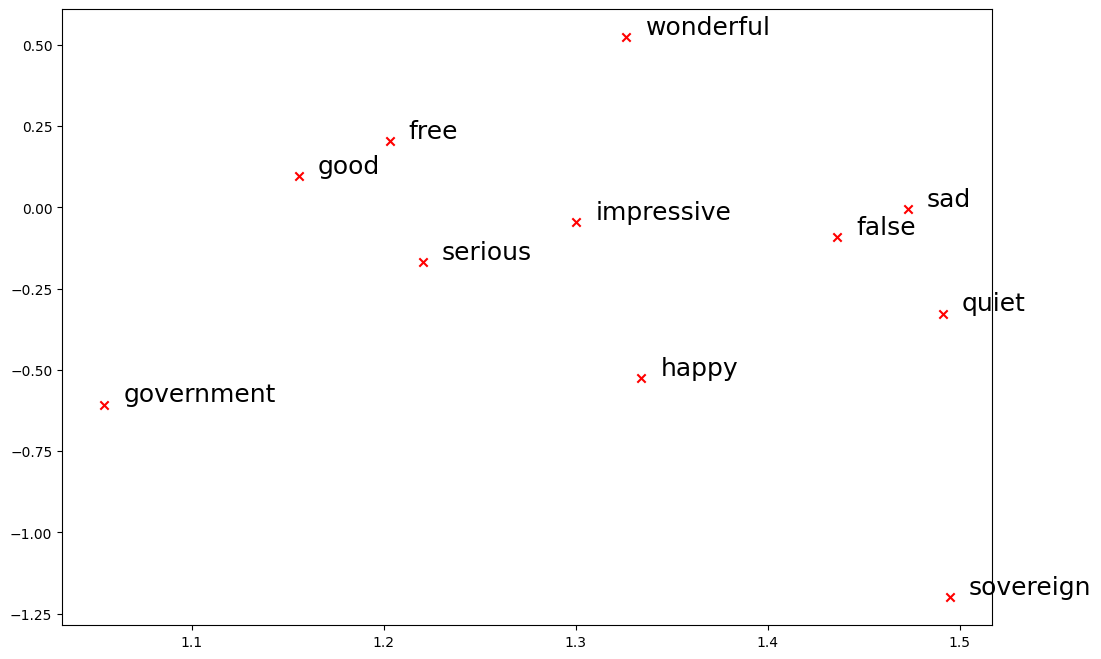

In [24]:
# 2D visualization
words = ["free","wonderful","quiet","impressive","good",'government','sad','happy','serious','false','sovereign']
plot_embeddings(M_reduced, word2Ind, words)

### Step 2: Multi-layer Perceptron (MLP) Classifier

**Exercise 4:** Build a Multi-layer Perceptron (MLP) Classifier to predicte the political party of the president using mean word vectors (the average of word vectors for each review) as features. Use the first 140 speeches for training and the others for testing. Report the accuracy on test data.

**Your Answer here:**


In [32]:
##############################################################################
### TODO: Create Average Word Vectors for each Review                      ###
##############################################################################
mean_vectors = [np.mean([model.wv[word] for word in doc if word in model.wv], axis=0) for doc in df['word'] if len(doc) > 0]
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning) # ignore warning during model training
    
    ##############################################################################
    ### TODO: Build an MLP Classifier and Report Accuracy on Test Data         ###
    ##############################################################################
X_train = mean_vectors[:140]
X_test = mean_vectors[140:]
y_train = df['party'][:140]
y_test = df['party'][140:]
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', random_state=1)
mlp_classifier.fit(X_train, y_train)
y_pred = mlp_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(accuracy))
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

Accuracy: 0.627906976744186


# Problem 2: BERT and Emotions Classification (50 points)

## Data

Demszky et al. (2020) introduced the GoEmotions dataset, consisting of 58K Reddit comments, each labeled for one or more of 27 emotions or neutral (28 in total). Specifically, the dataset encompasses comments from Reddit's inception in 2005 up to January 2019. The subreddits with at least 10k comments were selected, and non-English comments are removed. Demszky et al. (2020) preprocess the comments data to reduce profanity and balance between categories. Te be specific, the following preprocessings are performed: Reducing profanity, manual review, sentiment balancing, emotion balancing, subreddit balancing, and masking. After preprocessing, the size of the total GoEmotions dataset is 54,263, including 43,410 for training (80%), 5,426 for validation (10%), and 5,427 for test (10%).

There are 28 emotions: neutral, admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise. 

You can refer to the GoEmotions paper or HuggingFace: https://huggingface.co/datasets/go_emotions.

We only have a subsample of this dataset for your final project for simplicity. We have provided with the data file `reddit.tsv`.

## BERT Embeddings

**BERT** (Bidirectional Encoder Representations from Transformers) is a revolutionary model in the field of natural language processing (NLP) introduced by researchers at Google in 2018. BERT's breakthrough is its ability to train language models based on the entire set of words in a sentence or query (bidirectionally), rather than the traditional way of training on the order of words (left-to-right or right-to-left). This approach allows the model to capture the context of a word based on all of its surroundings, leading to a deeper understanding of language.

Here are some key concepts that are good to know:

- **Transformer**: BERT is built on the Transformer architecture, introduced in the paper "Attention is All You Need" by Vaswani et al. The Transformer model uses self-attention mechanisms to weigh the significance of different words in a sentence. Unlike previous models that processed words in sequence, the Transformer treats sentences as a whole, enabling parallel processing and significantly reducing training times.

- **Bidirectional Context**: BERT's key innovation is its bidirectional training of the Transformer. Traditional language models were limited to unidirectional training, which could only consider the context from one direction (either from left to right or vice versa). BERT, however, uses a "masked language model" (MLM) pre-training objective, where some percentage of the input tokens are masked at random, and the goal is to predict these masked tokens based on the context provided by the non-masked tokens in the sequence.

- **Pre-training** and **Fine-tuning**

    - Pre-training: BERT is pre-trained on a large corpus of text from the BookCorpus and English Wikipedia. During pre-training, it learns language representations by optimizing two objectives: the Masked Language Model (MLM) and Next Sentence Prediction (NSP). MLM helps BERT understand the bidirectional context of words, while NSP enables it to understand the relationships between sentences.
    
    - Fine-tuning: After pre-training, BERT can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering, sentiment analysis, and language inference, without substantial modifications to the model architecture.

Here are some technical details about BERT if you are interested:

- **Model size**: BERT comes in several sizes, the two primary variants being BERT-Base and BERT-Large. BERT-Base consists of 12 layers (transformer blocks), 768 hidden units (size of the embeddings), and 12 self-attention heads, totaling about 110 million parameters. BERT-Large upscales this to 24 layers, 1024 hidden units, and 16 self-attention heads, totaling about 340 million parameters.

- **Input representation**: BERT's input representation is designed to handle a wide variety of NLP tasks without modification. Each input embedding is a combination of three embeddings:

    - Token Embeddings: WordPiece embeddings with a 30,000 token vocabulary.
    
    - Segment Embeddings: Differentiated embeddings to distinguish between sentences in tasks that involve multiple sentences (e.g., question answering).
    
    - Positional Embeddings: To encode the sequence order of words.

- **Attention Mechanism**: The core of BERT's Transformer architecture is the attention mechanism, specifically "multi-head self-attention". This mechanism allows the model to focus on different parts of the input sequence when understanding each word, considering the entire context of the sentence or sequence, both to the left and the right of the target word.

https://lilianweng.github.io/posts/2019-01-31-lm/ is a great article to read, introducing a list of methods and algorithm in Natural Language Processing and Language Models. You can read it for your own interest and know more about the progress in NLP (until 5 years ago).

In [ ]:
# !pip install transformers

In [35]:
import pandas as pd
import numpy as np
import torch
from transformers import (
    BertModel,
    BertTokenizer,
)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

In [36]:
# Read data
df = pd.read_csv("reddit.tsv", sep="\t", header=None)
df.columns = ['text', 'emotion', 'id']
df.head()

,text,emotion,id
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [37]:
##############################################################################
### TODO: Construct a BERT tokenizer and model based on the pre-trained model 'bert-base-uncased' ###
### TODO: Encode the text into tokens ###
##############################################################################
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

In [38]:
# Generate BERT embeddings for text data
def get_bert_embeddings(text):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=50)
    
    # Forward pass through BERT model
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Extract the output embeddings and mean pooling
    embedding = outputs.last_hidden_state.mean(axis=(0, 1)).numpy()
    
    return embedding

In [39]:
# ~5-10 minutes running time
tqdm.pandas(desc="Applying BERT embeddings")

# Convert text to BERT embeddings
df['embedding'] = df['text'].progress_apply(get_bert_embeddings)

Applying BERT embeddings: 100%|██████████| 5427/5427 [10:56<00:00,  8.27it/s]


In [40]:
df.head()

,text,emotion,id,embedding
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,"[0.08825616, -0.0671884, 0.15275933, -0.310085..."
1,It's wonderful because it's awful. At not with.,0,ed5f85d,"[0.06496291, 0.1867005, 0.26324436, 0.097168, ..."
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,"[0.30238122, -0.19871931, 0.57909536, 0.101910..."
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,"[0.10757128, 0.116430484, 0.12003426, 0.152835..."
4,They got bored from haunting earth for thousan...,27,eem5uti,"[0.6161463, 0.04139359, 0.23162575, 0.30271912..."


In [41]:
# Save data with BERT embeddings to .pkl file so that we can use it later and avoid re-running the time-consuming codes above
with open('data_with_embeddings.pkl', 'wb') as f:
    pickle.dump(df, f)

In [42]:
# Load data with BERT embeddings
with open('data_with_embeddings.pkl', 'rb') as f1:
    df1 = pickle.load(f1)

df1.head()

,text,emotion,id,embedding
0,I’m really sorry about your situation :( Altho...,25,eecwqtt,"[0.08825616, -0.0671884, 0.15275933, -0.310085..."
1,It's wonderful because it's awful. At not with.,0,ed5f85d,"[0.06496291, 0.1867005, 0.26324436, 0.097168, ..."
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3,"[0.30238122, -0.19871931, 0.57909536, 0.101910..."
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1,"[0.10757128, 0.116430484, 0.12003426, 0.152835..."
4,They got bored from haunting earth for thousan...,27,eem5uti,"[0.6161463, 0.04139359, 0.23162575, 0.30271912..."


In [43]:
##############################################################################
### TODO: Use the BERT embeddings as features and the emotion as the target variable ###
### TODO: Split the data into training and testing sets (test_size=0.2) ###
##############################################################################
# Create an array of embeddings and the target variable
#X = np.array(df1['embedding'].tolist())
#y = df1['emotion'].values
X_train, X_test, y_train, y_test = train_test_split(df1['embedding'].tolist(),
                                                    df1['emotion'].values, test_size=0.2, random_state=42)
##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

In [44]:
##############################################################################
### TODO: Perform Logistic Regression to fit the training data, predict the emotion, 
### and calculate the prediction accuracy ###
##############################################################################

logreg = LogisticRegression(random_state=0, max_iter=100)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

Accuracy: 0.39226519337016574


In [45]:
##############################################################################
### TODO: Perform Random Forest to fit the training data, predict the emotion, 
### and calculate the prediction accuracy ###
##############################################################################
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest accuracy: {accuracy_rf}')

##############################################################################
#                               END OF YOUR CODE                             #
##############################################################################

Random Forest accuracy: 0.3370165745856354
